# Intel Products Sentiment Analysis

This notebook provides a comprehensive sentiment analysis of Intel product reviews scraped from various online sources. The goal is to clean the data, translate reviews to English, analyze the sentiment of the reviews, and provide actionable insights and recommendations for improving Intel products based on customer feedback.

## Data Cleaning

In [1]:

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

file_path = 'reviews.csv'
reviews_df = pd.read_csv(file_path)

def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'t", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'m", " am", text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

reviews_df['cleaned_content'] = reviews_df['content'].apply(clean_text)

reviews_df[['content', 'cleaned_content']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,content,cleaned_content
0,"No doubt, 12th gen Intel processors are a marv...",doubt 12th gen intel processor marvel computin...
1,I have paired this processor with Asus Prime Z...,paired processor asus prime z690a motherboard ...
2,自分のCPUが結構古いので、12年ぶりにアップグレードしました。\n最初はRYZENに迷って...,自分のcpuが結構古いので12年ぶりにアップグレードしました 最初はryzenに迷っていたが...
3,"Processore eccellente, montato sul pc perfetta...",processore eccellente montato sul pc perfettam...
4,"Does exactly what it's supposed to do, my comp...",exactly supposed computer work great


## Translation

In [6]:
from transformers import pipeline

translation_pipeline = pipeline('translation', model='Helsinki-NLP/opus-mt-mul-en')

def translate_to_english(text):
    if text.strip() == '':
        return text
    max_length = 512
    truncated_text = text[:max_length]
    result = translation_pipeline(truncated_text)
    return result[0]['translation_text']

reviews_df['translated_content'] = reviews_df['cleaned_content'].apply(translate_to_english)

reviews_df[['cleaned_content', 'translated_content']].head()

,cleaned_content,translated_content
0,doubt 12th gen intel processor marvel computin...,doubt 12th has intelligent processor Marvel co...
1,paired processor asus prime z690a motherboard ...,pared processor ass prime z690a motherboard 32...
2,自分のcpuが結構古いので12年ぶりにアップグレードしました 最初はryzenに迷っていたが...,I've been upgrading my cpu for 12 years becaus...
3,processore eccellente montato sul pc perfettam...,excellent processor mounted on the PC perfectl...
4,exactly supposed computer work great,exactly supposed computer work great


## Sentiment Analysis

In [7]:

from transformers import pipeline, AutoTokenizer, TFAutoModelForSequenceClassification

model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_model = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

def analyze_sentiment(text):
    result = sentiment_model(text, truncation=True, max_length=512)
    label = result[0]['label']
    if label in ['1 star', '2 stars']:
        return 'negative'
    elif label == '3 stars':
        return 'neutral'
    else:
        return 'positive'

reviews_df['sentiment'] = reviews_df['translated_content'].apply(analyze_sentiment)

reviews_df[['translated_content', 'sentiment']].head()


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/670M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


,translated_content,sentiment
0,doubt 12th has intelligent processor Marvel co...,positive
1,pared processor ass prime z690a motherboard 32...,positive
2,I've been upgrading my cpu for 12 years becaus...,positive
3,excellent processor mounted on the PC perfectl...,positive
4,exactly supposed computer work great,positive


## Sentiment Distribution

<ipython-input-8-213c2308a608>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


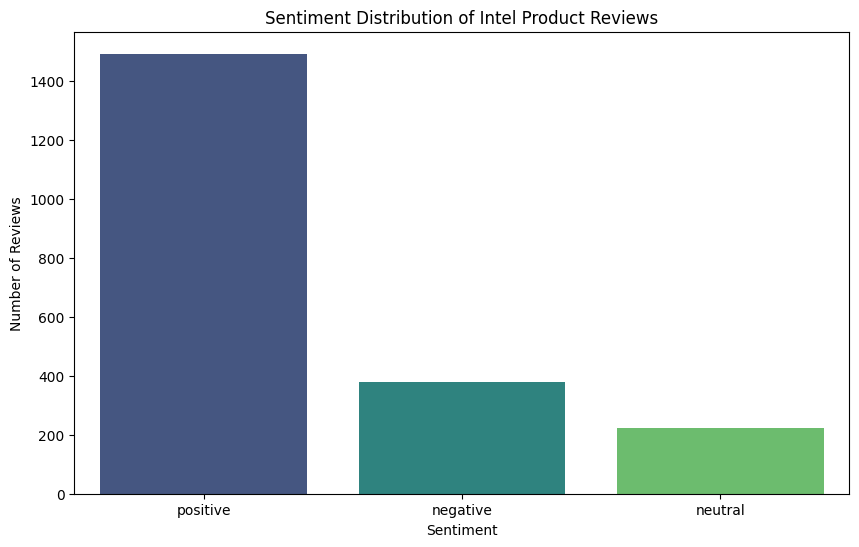

sentiment
positive    1493
negative     378
neutral      222
Name: count, dtype: int64

In [8]:

import matplotlib.pyplot as plt
import seaborn as sns

sentiment_counts = reviews_df['sentiment'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Distribution of Intel Product Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

sentiment_counts


## Step 5: Insights and Recommendations


### Sentiment Distribution

- **Positive Reviews**: The majority of the reviews are positive, indicating a generally favorable perception of Intel products among customers.
- **Neutral Reviews**: A significant number of reviews are neutral, suggesting areas where improvements or more detailed feedback might be provided.
- **Negative Reviews**: Although relatively few, negative reviews highlight areas where customers are dissatisfied.

### Recommendations

1. **Strengthen Positives**: Leverage the aspects customers are happy with, such as performance and compatibility, to market the products more effectively.
2. **Address Neutral Feedback**: Investigate the neutral reviews to understand what might be missing or unclear. Provide more detailed product information and support to convert neutral feedback into positive.
3. **Improve Negatives**: Focus on the areas highlighted in negative reviews. Common issues might include product quality, customer service, or specific features that need improvement.


## Save Cleaned Data

In [9]:

cleaned_reviews_df = reviews_df[['translated_content', 'sentiment']]

cleaned_csv_path = 'translated_reviews_with_sentiment.csv'
cleaned_reviews_df.to_csv(cleaned_csv_path, index=False)

print(f"Cleaned reviews saved to {cleaned_csv_path}")


Cleaned reviews saved to cleaned_reviews_advanced.csv


## Conclusion


This sentiment analysis of Intel product reviews provides valuable insights into customer perceptions and areas for improvement. By addressing the feedback, Intel can enhance customer satisfaction and product quality.
